# Bias Evaluation : AIF360
***

Quantification of model bias in terms of fairness against protected groups before and after implementation of mitigation methods

## Terminology
***

***Favorable label:*** A label whose value corresponds to an outcome that provides an advantage to the recipient (such as receiving a loan, being hired for a job, not being arrested)

***Protected attribute:*** An attribute that partitions a population into groups whose outcomes should have parity (such as race, gender, caste, and religion)

***Privileged value (of a protected attribute):*** A protected attribute value indicating a group that has historically been at a systemic advantage

***Fairness metric:*** A quantification of unwanted bias in training data or models

***Discrimination/unwanted bias:*** Although bias can refer to any form of preference, fair or unfair, our focus is on undesirable bias or discrimination, which is when specific privileged groups are placed at a systematic advantage and specific unprivileged groups are placed at a systematic disadvantage. This relates to attributes such as race, gender, age, and sexual orientation.


## Structure of Evaluation & Intervention
***
<img src="images/aif360_pipeline.png" width="700" height="500" align="center"/>

### Three Perspectives of Fairness in ML algorithms
***

[linkedin article](https://www.linkedin.com/pulse/whats-new-deep-learning-research-reducing-bias-models-jesus-rodriguez/)

***1. Data vs Mode***

Fairness may be quantified in the training dataset or in the learned model

***2. Group vs Individual***

Group fairness partitions a population into groups defined by protected attributes and seeks for some statistical measure to be equal across all groups. Individual fairness seeks for similar individuals to be treated similarly.


***3. WAE vs WYSIWYG (We are all equal vs What you see is what you get)***

WAE says that fairness is an equal distirbution of skills and opportunities among the participants in an ML task, attributing differences in outcome distributions to structural bias and not a difference in distribution to ability. WYSIWYG says that observations reflect ability with respect to a task.

> If the application follows the WAE worldview, then the demographic parity metrics should be used: disparate_impact and statistical_parity_difference.  If the application follows the WYSIWYG worldview, then the equality of odds metrics should be used: average_odds_difference and average_abs_odds_difference.  Other group fairness metrics (some are often labeled equality of opportunity) lie in-between the two worldviews and may be used appropriately: false_negative_rate_ratio, false_negative_rate_difference, false_positive_rate_ratio, false_positive_rate_difference, false_discovery_rate_ratio, false_discovery_rate_difference, false_omission_rate_ratio, false_omission_rate_difference, error_rate_ratio, and error_rate_difference.  To choose among these, the right side of the decision tree here may be consulted.

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(context='talk', style='whitegrid')
from IPython.display import display, Markdown

from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import accuracy_score

# from aif360.sklearn.metrics import mdss_bias_scan, mdss_bias_score
import aif360
import utilities
import global_variables as gv

In [28]:
from aif360.datasets import StandardDataset, BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.explainers import MetricTextExplainer, MetricJSONExplainer

In [92]:
df = pd.read_csv(gv.data_link)
pd.set_option('display.max_columns', None)
df.drop('Unnamed: 0', axis=1, inplace=True)

X = df.iloc[:,:61]
X['sex'] = df.loc[:,'gender']
X2['race'] = df.loc[:,'race']
X3['age'] = df.loc[:,'age']

target = gv.outcomes[7]
X['target'] = df[target]
X2['target'] = df[target]
X3['target'] = df[target]

In [93]:
X

,30850-0.0,30780-0.0,30690-0.0,30790-0.0,23101-0.0,23099-0.0,48-0.0,23100-0.0,30710-0.0,30760-0.0,30640-0.0,30750-0.0,49-0.0,30770-0.0,30740-0.0,30630-0.0,30870-0.0,21001-0.0,1488-0.0,4079-0.0,1299-0.0,21003-0.0,1160-0.0,1438-0.0,4080-0.0,1458-0.0,1528-0.0,1319-0.0,845-0.0,1289-0.0,1309-0.0,1418-0.0,1329-0.0,1220-0.0,1428-0.0,1249-0.0,1349-0.0,1369-0.0,20117-0.0,2100-0.0,2654-0.0,1339-0.0,21000-0.0,2050-0.0,1408-0.0,1200-0.0,1538-0.0,31-0.0,6138-0.0,1359-0.0,1389-0.0,1478-0.0,2090-0.0,1508-0.0,1379-0.0,6142-0.0,1468-0.0,1548-0.0,1239-0.0,1448-0.0,hypertension,sex,target
0,0.50800,3.88800,6.47700,65.1984,45.2,35.6,74.0,25.0,0.34,1.70600,1.21100,35.065,102.0,26.339,5.62200,1.59300,0.97700,24.5790,6.0,77.0,10.0,54.0,7.0,10.0,110.0,3.73,2.0,0.0,23.52,6.0,2.0,3,2,0,0,1,1,1,2,1,6,2,0,2,1,3,2,0,1,2,1,1,1,3,1,1,3,2,0,3,0,Female,1
1,13.08800,3.52000,5.51200,15.4000,74.6,36.5,120.0,42.9,3.94,1.17300,1.01900,40.900,113.0,10.701,5.05200,1.39000,2.35800,35.0861,2.0,91.0,2.0,65.0,9.0,12.0,166.0,7.00,2.4,0.0,16.00,2.0,1.0,2,2,0,1,1,4,2,2,0,7,2,0,1,3,2,0,1,3,3,1,1,0,2,2,1,5,2,0,1,1,Male,0
2,9.73364,4.10892,6.47949,50.8588,71.7,29.7,112.0,30.3,3.88,1.58546,1.22432,84.100,107.0,18.763,13.71763,1.74423,2.78764,30.7934,0.0,99.0,2.0,55.0,7.0,10.0,135.0,7.00,2.0,0.0,21.00,3.0,1.0,2,1,0,0,1,2,1,2,0,7,2,0,1,2,2,1,1,3,3,2,1,0,2,2,1,4,2,0,3,1,Male,1
3,1.78800,2.88700,5.56500,56.5183,40.2,29.8,67.0,17.0,0.87,2.11500,0.81000,36.400,91.0,31.672,4.82700,1.89100,1.15700,20.7577,0.0,71.0,5.0,49.0,8.0,14.0,116.0,5.00,3.0,1.0,18.00,5.0,1.0,2,2,0,0,4,1,2,2,0,7,2,2,1,2,1,2,0,6,2,2,1,0,2,2,1,3,2,0,3,0,Female,1
4,0.75600,2.67000,4.68000,4.7700,46.5,30.1,85.0,20.0,0.18,1.49300,0.73300,34.200,105.0,42.209,5.06300,1.86900,1.67700,25.9766,7.0,73.0,4.0,61.0,7.0,2.0,113.0,7.00,4.0,2.0,16.00,3.0,3.0,3,2,1,1,4,1,1,2,0,7,3,0,1,3,1,0,0,3,3,1,2,0,1,1,1,4,2,0,3,1,Female,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86950,1.09949,3.87500,6.19000,169.2000,46.9,35.8,94.0,26.2,3.83,1.00800,1.30600,24.500,109.0,16.010,4.60400,1.42100,5.14200,29.2822,0.0,82.0,3.0,68.0,7.0,8.0,151.0,5.00,6.0,1.0,15.00,6.0,2.0,2,0,1,3,2,3,2,2,0,8,3,0,1,1,2,0,0,3,1,1,1,0,1,2,2,4,3,0,3,1,Female,1
86951,9.03600,2.46700,4.03500,44.6578,66.3,36.9,114.0,38.7,2.24,1.08700,0.77300,32.100,110.0,22.351,3.79600,1.18800,1.01200,34.2857,0.0,90.0,1.0,58.0,5.0,26.0,129.0,1.00,0.0,0.0,15.00,4.0,2.0,1,1,0,3,3,3,1,2,0,4,3,0,1,2,2,0,1,5,2,1,2,0,2,1,1,4,1,0,2,1,Male,0
86952,0.48500,3.80200,6.50700,45.3675,41.6,37.1,82.0,24.5,0.52,1.85700,0.96900,32.800,106.0,21.654,5.03400,2.14200,2.15200,26.1461,4.0,69.0,3.0,57.0,8.0,7.0,140.0,7.00,3.0,0.0,16.00,1.0,0.0,2,3,0,3,4,1,1,2,0,6,2,0,1,2,3,0,0,4,2,1,2,1,2,1,1,2,2,0,3,0,Female,0
86953,0.72500,2.86300,4.66400,5.0900,44.9,46.3,102.0,38.7,2.75,1.15900,0.89800,33.200,110.0,23.647,5.67300,1.36500,2.13400,31.4652,0.0,73.0,3.0,64.0,6.0,4.0,148.0,7.00,3.0,0.0,16.00,4.0,6.0,3,1,0,1,1,1,2,1,0,2,1,0,1,1,3,2,0,3,3,2,2,1,1,2,2,1,3,0,3,1,Female,0


In [94]:
X['sex']=X['sex'].map(gv.binary_sex)
X2['race']=X2['race'].map(gv.binary_race)

In [95]:
# bin age by decade
bins = [30, 40, 50, 60, 70, 80]
labels = ['30-39', '40-49', '50-59', '60-69', '70-79']
X3['age'] = pd.cut(x = X3['age'], bins = bins, labels = labels, include_lowest = True)

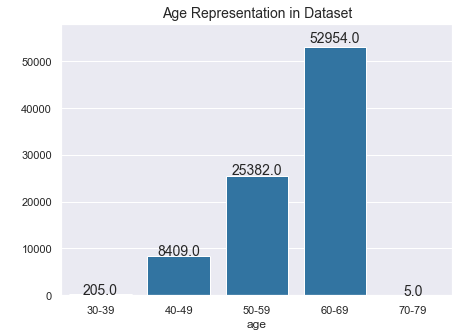

In [97]:
# plotting data on chart
# define Seaborn color palette to use
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(7,5))
ax = sns.countplot(x=X3['age'],
                   order = labels,
                   color='tab:blue',)
plt.title('Age Representation in Dataset', fontsize=14)
plt.xlabel('age')
plt.ylabel(' ')
plt.ylim(0, 58000)
utilities.show_values(ax,space=0.1)
plt.savefig('charts/age_binned.png', bbox_inches='tight')

### 1. Data Bias Checking

#### Sex

In [83]:
priv_1 = [{'sex': 1}]
unpriv_1 = [{'sex': 0}]
favorable_label = 1 
unfavorable_label = 0

In [89]:
#Create binary label dataset that can be used by bias mitigation algorithms
dataset_1 = BinaryLabelDataset(favorable_label=favorable_label,
                                unfavorable_label=unfavorable_label,
                                df=X,
                                label_names=['target'],
                                protected_attribute_names=[ 'sex'],
                                unprivileged_protected_attributes=unpriv_1)

In [77]:
# create explainers
text_expl = MetricTextExplainer(bldm)
json_expl = MetricJSONExplainer(bldm)

NameError: name 'bldm' is not defined

In [90]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_1, 
                                             unprivileged_groups=unpriv_1,
                                             privileged_groups=priv_1)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.011648


In [91]:
min_max_scaler = MaxAbsScaler()
dataset_1.features= min_max_scaler.fit_transform(dataset_1.features)
metric_scaled_train = BinaryLabelDatasetMetric(dataset_1, 
                             unprivileged_groups=unpriv_1,
                             privileged_groups=priv_1)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())

#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Difference in mean outcomes between unprivileged and privileged groups = -0.011648


In [69]:
dataset_1.features

array([[ 0.508  ,  3.888  ,  6.477  , ...,  3.     ,  0.     ,  0.     ],
       [13.088  ,  3.52   ,  5.512  , ...,  1.     ,  1.     ,  1.     ],
       [ 9.73364,  4.10892,  6.47949, ...,  3.     ,  1.     ,  1.     ],
       ...,
       [ 0.485  ,  3.802  ,  6.507  , ...,  3.     ,  0.     ,  0.     ],
       [ 0.725  ,  2.863  ,  4.664  , ...,  3.     ,  1.     ,  0.     ],
       [12.04   ,  3.358  ,  5.184  , ...,  2.     ,  1.     ,  1.     ]])

#### Race

In [ ]:
privileged_groups2 = [{'race': 1}]
unprivileged_groups2 = [{'race': 0}]

metric_orig_train = BinaryLabelDatasetMetric(X2, 
                                             unprivileged_groups=unprivileged_groups2,
                                             privileged_groups=privileged_groups2)

#### Age (grouped by decade)

In [ ]:
privileged_groups3 = [{'age': 1}]
unprivileged_groups3 = [{'age': 0}]

metric_orig_train = BinaryLabelDatasetMetric(X3, 
                                             unprivileged_groups=unprivileged_groups3,
                                             privileged_groups=privileged_groups3)

### 2. Evaluation of Bias in Models

<b>Average Odds Difference:    </b> $ \tfrac{1}{2}\left[(FPR_{D = \text{unprivileged}} - FPR_{D = \text{privileged}}) + (TPR_{D = \text{privileged}} - TPR_{D = \text{unprivileged}}))\right] $

<b>Statistical Parity Difference:    </b>$ Pr(\hat{Y} = 1 | D = \text{unprivileged}) - Pr(\hat{Y} = 1 | D = \text{privileged}) $


<b>Equal Opportunity Difference:    </b>$ TPR_{D = \text{unprivileged}} - TPR_{D = \text{privileged}} $

<b>Theil Index:    </b>$ \frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln\frac{b_{i}}{\mu}, \text{with} b_i = \hat{y}_i - y_i + 1 $

<b>Disparate Impact:    </b> $ \frac{Pr(Y = 1 | D = \text{unprivileged})} {Pr(Y = 1 | D = \text{privileged})}$

### Preparation.

Define privileged and unprivileged groups for each protected attribute

#### Sex. Privileged group: Males (1) Unprivileged group: Females (0)

In [ ]:
male_df = original_output[original_output['Sex']==1]
num_privileged = male_df.shape[0]
female_df = original_output[original_output['Sex']==0]
num_unprivileged = female_df.shape[0]  

#### Gender. Privileged group: White (1) Unprivileged group: Non-white (0)

#### Age

### Metric 1. Disparate Impact Ratio

The ***disparate impact ratio*** is defined as the ratio of the proportion of positive predictions (y'=1) for facet d over the proportion of positive predicitons (y'=1) for facet a.

Industry generally considers the four-fifths rule: if the unprivileged group receives a positive outcome less than 80% of their proportion of the privileged group it is considered a disparate impact violation.


In [ ]:
unprivileged_outcomes = female_df[female_df['prediction']==1].shape[0]
unprivileged_ratio = unprivileged_outcomes/num_unprivileged

In [ ]:
privileged_outcomes = male_df[male_df['prediction']==1].shape[0]
privileged_ratio = privileged_outcomes/num_privileged

In [ ]:
disparate_impact = unprivileged_ratio / privileged_ratio

### Metric 2. Statistical Parity Difference

### Metric 3. Equal Opportunity Difference

### Metric 4. Average Odds Difference

### Theil Index